# Nutrition Match Optimization
> To get full detailed problem information, [click here.](https://code.aliyun.com/mindopt001/mindopt-open-examples/blob/master/doc/example_2.md)

A classical optimization problem. Asking that how to ensure balanced nutrition in the lowest cost.



In [1]:
"""Basic Information"""
import numpy as np

foodName = {
            0:'Cheese burger',
            1:'ham sandwich',
            2:'Ham-burger',
            3:'Fish sandwich',
            4:'Chicken sandwich',
            5:'Fries',
            6:'Sausage biscuit',
            7:'Lowfat milk',
            8:'Orange juice'
            }
costList = np.array([1.84, 2.19, 1.84, 1.44, 2.29, 0.77, 1.29, 0.60, 0.72])
types = len(foodName)
INFINITY = 1000000
nutritionTypes = 8
nutritionBound = np.array([[2000, 355, 55, 100, 100, 100, 100, 0], 
                          [INFINITY, 375, INFINITY, INFINITY, INFINITY, INFINITY, INFINITY, 75]])
nutritionTable = np.array([
                          [510,370	,500,370,400,220,345,110,80],
                          [34,55	,42	,38	,42	,26,27	,12	,20],
                          [28,24,25,14,31	,3	,15	,9	,1],
                          [15,15	,6	,2	,8	,0	,4	,10	,2],
                          [6,10	,2	,0	,15	,15	,0	,4	,120],
                          [30	,20	,25	,15	,15	,0	,20	,30	,2],
                          [20	,20	,20	,10	,8	,2	,15	,0	,2],
                          [4	,7.5,3.5,5	,7.3,2.6,4.1,8,12],
                          ])


# Application Architecture Design
- Programming Language: Python
- Main Algorithm: Genetic Algorithm (GA)



## 0. Solution Form
A list of volumes of all kinds of food, and the cost of this plan to avoid recompute it.

In [2]:
"""Solution, in GA, it was called as 'Chromosome'."""

class solution:

    def __init__(self, schedul) -> None:
        self.schedul = np.array(schedul)
        self.cost = solution.getCost(self.schedul)
    

    def getCost(schedul)->float:
        sum = 0.0
        for i in range(types):
            sum += schedul[i] * costList[i]

        return sum

    def __str__(self) -> str:
        return str(self.schedul)+':'+str(solution.getCost(self.schedul))

# Test
slt = solution([1,2,3,4,5,6,7,8,9])
print(slt.schedul)
print(slt.cost)

[1 2 3 4 5 6 7 8 9]
53.879999999999995


## 1. Hybridization & Mutation & Breed
We use these 2 methods to generate new solutions from old solutions.

### 1.0 Hybridization
Hybridization is implemented via method like this: for 2 elements in 2 old solutions that have same index, select one of them randomly.

### 1.1 Mutation
Mutation is implemented via randomly select some elements and substitute it with a random number. Whether or not mutation occurs is determined by a manageable probablity.

But to 

### 1.2 Breed
Combine 2 methods above, we can generate a new solution from 2 old solutions. I call this process as "breed".

In [3]:
"""Hybridization & Mutation & Breed"""
import random as rd
import copy

def hybridize(p1: solution, p2:solution)->solution:
    child = solution(p1.schedul)
    for i in range(types):
        # Control the hybridization probablity through here.
        if rd.randint(1,3)==1:
            child.schedul[i] = p2.schedul[i]

    return child


mutateProbablity = float(0.4)
def willMutate()->bool:
    """Decide whether to mutate or not."""
    return mutateProbablity * 1000 >= rd.randint(0,1000)

def isValid(p:solution)->bool:
    # Count all the nutritions' contents.
    nutritions = np.zeros((1, nutritionTypes))
    for i in range(types):
        for j in range(nutritionTypes):
            nutritions[0, j] += p.schedul[i] * nutritionTable[j, i]

    # print(p)

    for i in range(nutritionTypes):
        if nutritions[0, i] < nutritionBound[0, i] or nutritions[0, i] > nutritionBound[1, i]:
            return False

    return True


def mutate(child:solution)->solution:
    rt = copy.deepcopy(child)
    for i in range(types):
        if willMutate():
            rt.schedul[i] = rd.randint(0, 4) + rd.randint(0, 10000) * 10e-5

    while not isValid(rt) or all(rt.schedul==child.schedul):
        rt = copy.deepcopy(child)
        for i in range(types):
            if willMutate():
                rt.schedul[i] = rd.randint(0, 4) + rd.randint(0,10000) * 10e-5

    return rt


def breed(p1:solution, p2:solution)->solution:
    child = solution(p1.schedul)
    for i in range(types):
        if rd.randint(0,1) == 1:
            child.schedul[i] = p2.schedul[i]

    child = mutate(child)
    child.cost=solution.getCost(child.schedul)
    return child
    


# Test
"""In some cases, it's impossible to make a solution valid via changing constant number of values."""
ini = solution([4.8,2,1,1,3,0.5,0.1,1,0.4])

import matplotlib.pyplot as plt
import time
"""Get the optimal value of these parameters."""
def test():
    pb = [0.1, 0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    avg = []
    print("Calculating...")
    for item in pb:
        mutateProbablity = item
        tBegin = time.time()
        for i in range(100):
            mutate(ini)
        avg.append((time.time()-tBegin)/100)
    print("Calculation Done!")
    
    # show
    plt.plot(pb, avg)
    plt.grid(True, 'both')
    plt.xlabel('Mutate Probabilities')
    plt.ylabel('Average Time')
    plt.title('The Relationship Between Average Calculation Time and Mutation Probabilities')
    plt.savefig('./../rsrc/MutationProb.jpg')
    plt.show()

# test()


## 2. Evolution
The process that breeding many generations to screen out the optimal individual.

### 2.0. Population
There are 2 parameters of population:
- attritionRate: Decide how many individuals have no right to breed their own children.
- Population: Decide how many individuals in each generation. 

### 2.1. Evolution
Choose 2 of the survivals randomly, breed their children many times till the generation is full.

In [4]:
class GA:
    def __init__(self, pop=100, rate=0.3) -> None:
        self.population = pop
        self.attritionRate = rate
        self.num = int(pop*rate)

        self.generation = []
        for i in range(self.population):
            self.generation.append(mutate(ini))

        
    def evolute(self)->list:
        self.generation.sort(key=lambda x: solution.getCost(x.schedul))
        survivals = self.generation[:self.num]
        for i in range(self.population):
            p1 = rd.randint(0, self.num-1)
            p2 = rd.randint(0, self.num-1)
            self.generation[i] = breed(survivals[p1], survivals[p2])

        return self.generation

    
    def startEvolution(self, t:int)->solution:
        for i in range(t):
            self.evolute()

        self.generation.sort(key=lambda x: solution.getCost(x.schedul))
        return self.generation[0]

## 3. Analysis
There are 4 main variables who may have great effect on convergence velocity, optimal solution cost etc. So I will generate 3 charts to reveal and describe the relationships between them:
- Mutation Probability.
- Population
- Attrition Rate
- Generations
  

In [7]:
def getAxisData():
    # population
    opt_P = []
    popList = [10, 50, 90, 130]
    for p in popList:
        algo = GA(pop=p)
        opt = []
        for i in range(1, 101):
            algo.evolute()
            opt.append(solution.getCost(
                min(algo.generation, key=lambda x: solution.getCost(x.schedul)).schedul))
        opt_P.append((p,opt))

    # Mutation
    opt_M = []
    mp = [0.3, 0.5, 0.7, 0.9]
    for p in mp:
        algo = GA()
        mutateProbablity = p
        opt = []
        for i in range(1, 101):
            algo.evolute()
            opt.append(solution.getCost(
                min(algo.generation, key=lambda x: solution.getCost(x.schedul)).schedul))
        opt_M.append((p,opt))
    mutateProbablity = 0.3

    # Attrition Rate
    opt_A = []
    ar = [0.3, 0.5, 0.7, 0.9]
    for r in ar:
        algo = GA(rate=r)
        opt = []
        for i in range(1, 101):
            algo.evolute()
            opt.append(solution.getCost(
                min(algo.generation, key=lambda x: solution.getCost(x.schedul)).schedul))
        opt_A.append((r,opt))

    return (opt_P, opt_M, opt_A)


Xaxes = range(1, 101)
YaxesSet = getAxisData()


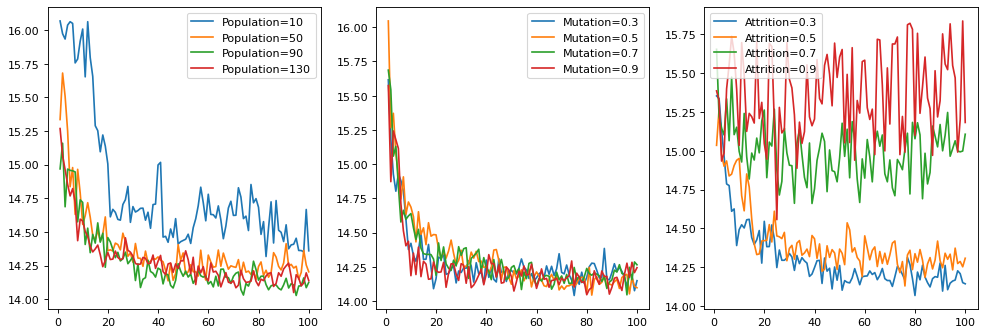

In [11]:
"""
Visualization
"""

def visualize():
    plt.figure(figsize=(15, 5), dpi=80)
    plt.figure(1)
    plt.title("The Effect of 3 Factors")

    p1 = plt.subplot(131)
    for i in YaxesSet[0]:
        p = i[0]
        opt = i[1]
        p1.plot(Xaxes, opt, label='Population='+str(p))
        p1.xlabel = 'Generation'
        p1.ylabel = 'Optimal Cost'
        p1.legend()

    p2 = plt.subplot(132)
    for i in YaxesSet[1]:
        p = i[0]
        opt = i[1]
        p2.plot(Xaxes, opt, label='Mutation='+str(p))
        p2.xlabel = 'Generation'
        p2.ylabel = 'Optimal Cost'
        p2.legend()

    p3 = plt.subplot(133)
    for i in YaxesSet[2]:
        p = i[0]
        opt = i[1]
        p3.plot(Xaxes, opt, label='Attrition='+str(p))
        p3.xlabel = 'Generation'
        p3.ylabel = 'Optimal Cost'
        p3.legend()

    plt.show()


visualize()


# Conclusion
